CFE Data Assimilation of USGS streamflow data. Synthetic Forcing Data example to test methodology and 1-18 hour forecast. 

In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta

sys.path.insert(0, './CFE')
#import bmi_cfe_originial
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI


(750.0, 780.0)

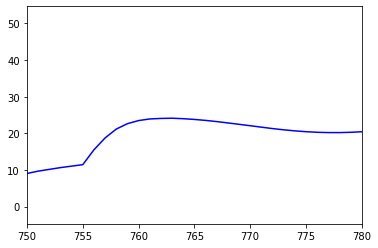

In [2]:
# Get Synthetic Observations (USGS)
cfe_obs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_obs.initialize(cfg_file='./CFE/config_cfe_synthetic.json')

# Open forcing file
with open(cfe_obs.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
# Make empty list to plot
OBSERVATIONS_LIST = []

# Loop through precipitation in forcing data to set values
for i, precip in enumerate(df_forcing['APCP_surface_0']): #i is RAINRATE
    cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
    cfe_obs.update()
    # Get streamflow based on sin wave to see variation in synthetic observed streamflow
    OBSERVATIONS_LIST.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)

cfe_obs.finalize()

# See plot to make sure it works
plt.plot(OBSERVATIONS_LIST,color = 'blue')
plt.xlim(750,780)

In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()

Final Framework for running each synthetic CFE model, EnKF DA, and synthetic observations

In [4]:
#Make empty matrices for plotting
cfeOpen_ensa    = []
cfeAnalysis_ens = []

## Loop through n different precipitation files for forcing. Max is 100 from forcing data
n_loop = 2
for loop in range(n_loop):
    p = 'APCP_surface_' + str(loop) #set p to each synthetic forcing data
    
    # Make empty matrices for plotting
    cfeOpen = []
    cfePeturbed = []
    cfeAnalysis = []
    cfeEnKF = []
    
    # Initialize Case study files
    cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json')
    
    ## Loop through time. Set values for each model and get values
    for i, precip in enumerate(df_forcing[str(p)]):

        # Set values for each CFE model. Adding precipitation since we are using an uncalibrated model to see flow result
        cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3) #value of precip from forcing data in loop
        cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
        cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
        
        # Update usgs data and get value to put into EnKF
        obs = OBSERVATIONS_LIST[i]
        enkf.set_value('validity', 1)

        # set observations to plot without EnKF for future forecast
        if i>=768:
            enkf.set_value('validity', 0)

        # Update CFE open and peturbed. Get value for peturbed stats. 
        cfe_open.update()
        cfe_peturbed.update()
        
        # Get state variable originial values from CFE Peturbed to update in EnKF
        soil_storage_avail             = cfe_peturbed.get_value('soil_storage_avail_m')
        soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
        storage_max_m                  = cfe_peturbed.get_value("storage_max_out_m")
        surface_runoff                 = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')

        # Set outflow for CFE Open and CFE Peturbed to plot
        outflow        = cfe_open.get_value('land_surface_water__runoff_depth')
        cfeOpen.append(outflow) #for plotting
        
        # Get mean and covariance of CFE Peturbed outflor of ensemble runs for EnKF
        outflow_peturb       = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
        outflow_peturb_mean  = np.mean(outflow_peturb)
        outflow_peturb_covar = np.cov(outflow_peturb)
        cfePeturbed.append(outflow_peturb_mean) # For plotting

        # Set EnKF state variable values to state variables from CFE Petubred
        enkf.set_value('soil_storage_avail_m', soil_storage_avail) 
        enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) 
        enkf.set_value('surface_runoff_depth_m', surface_runoff)
        enkf.set_value('storage_max_m',storage_max_m)

        # Set EnkF values usgs, mean, and covariance (from CFE Peturbed)
        enkf.set_value('x', np.array([outflow_peturb_mean]))
        enkf.set_value('P', np.array([outflow_peturb_covar]))
        enkf.set_value('z', np.array([obs]))
        #enkf_validity=enkf.set_value('validity',validity) #check validity if needed
        enkf.update()
        
        # For plotting if needed
        outflow_enkf = enkf.get_value('enkf')
        cfeEnKF.append(outflow_enkf)
        
        # Get updated state variable values from EnKF to pass into CFE Analysis
        state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
        state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
        # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
        state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

        # Set CFE analysis state variable changes from EnKF to get final true streamflow values
        cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) 
        cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) 
        cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
        cfe_analysis.update() #get new streamflow value based on state var change
        
        # For plotting CFE Analysis from newly updated state variables. FINAL MODEL! 
        outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
        cfeAnalysis.append(outflow_analysis) 

        # Get CFE Analysis state variables to then pass back into CFE Peturbed 
        cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
        cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
        cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

        # Set updated state variables into CFE Peturbed for the loop of updating state variables to continue! 
        cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
        cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
        cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)

    # Append models results from last hour of data assimilation for the 18 hour forecast
    cfeOpen_ensa.append(np.divide(abs(np.subtract(cfeOpen[767:],OBSERVATIONS_LIST[767:])),OBSERVATIONS_LIST[767:]))
    cfeAnalysis_ens.append(np.divide(abs(np.subtract(cfeAnalysis[767:],OBSERVATIONS_LIST[767:])),OBSERVATIONS_LIST[767:]))
    
    # Get mean of each hour in 18hour forecast
    cfeOpen_ensa_mean=np.mean(cfeOpen_ensa,axis=0)
    cfeanalysis_ensa_mean=np.mean(cfeAnalysis_ens,axis=0)
    
# Finalize the models!  
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
enkf.finalize()


initialized 10
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3121136221931379
EnKF Code predicted, X Post [9.44907678]
surface_runoff_ratio [2.16166509]
Leftover vol 0.0
surface _runoff [2.16166509]
***********over estimaiton ratio [1.]
Observation BMI [9.14803171]
CFE [20.14427893]
enkf [9.44907678]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2957114578598735
EnKF Code predicted, X Post [16.47410483]
surface_runoff_ratio [3.86476543]
Leftover vol 0.0
surface _runoff [3.86476543]
***********over estimaiton ratio [1.]
Observation BMI [16.75252741]
CFE [39.65075156]
enkf [16.47410483]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28072802840953426
EnKF Code predicted, X Post [22.1448819]
surface_runoff_ratio [1.43855031]
Leftover vol [56.5089738]
surface _runoff [1.43855031]
***********over estimaiton ratio [0.28154859]
Observation BMI [22.40183725]
CFE [78.65385571]
enkf [22.144881

self.f 1.0
soil_storage_deficit_from CFE 0.16074573073185794
EnKF Code predicted, X Post [2.1303932]
surface_runoff_ratio [0.14477326]
Leftover vol 0.0
surface _runoff [0.14477326]
***********over estimaiton ratio [1.]
Observation BMI [2.19477017]
CFE [2.71806054]
enkf [2.1303932]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16874301094255306
EnKF Code predicted, X Post [1.36384996]
***********under estimaiton ratio [1.17478795]
Observation BMI [1.6166818]
CFE [1.16093288]
enkf [1.36384996]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17661029940438366
EnKF Code predicted, X Post [1.41074332]
***********under estimaiton ratio [3.44827882]
Observation BMI [1.12415109]
CFE [0.40911521]
enkf [1.41074332]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1843497090675439
EnKF Code predicted, X Post [0.618917]
***********under estimaiton ratio [3.15258307]
Observation BMI [0.67528419]
CFE 

EnKF Code predicted, X Post [1.06152807]
***********under estimaiton ratio [61.46680039]
Observation BMI [1.77719031]
CFE [0.01726994]
enkf [1.06152807]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2677711742772404
EnKF Code predicted, X Post [0.43214722]
***********under estimaiton ratio [20.12910325]
Observation BMI [1.55290837]
CFE [0.02146878]
enkf [0.43214722]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.27402880998218804
EnKF Code predicted, X Post [0.24834339]
***********under estimaiton ratio [19.34204132]
Observation BMI [1.26745778]
CFE [0.01283956]
enkf [0.24834339]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28018473098068386
EnKF Code predicted, X Post [0.5819719]
***********under estimaiton ratio [37.0115754]
Observation BMI [0.93221961]
CFE [0.01572405]
enkf [0.5819719]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28624059059388

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16275860556059618
EnKF Code predicted, X Post [9.73321891]
surface_runoff_ratio [0.68659731]
Leftover vol [16.7611041]
surface _runoff [0.68659731]
***********over estimaiton ratio [0.36736998]
Observation BMI [9.45964434]
CFE [26.494323]
enkf [9.73321891]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.15928515032136514
EnKF Code predicted, X Post [9.1590339]
surface_runoff_ratio [1.59984641]
Leftover vol 0.0
surface _runoff [1.59984641]
***********over estimaiton ratio [1.]
Observation BMI [9.26498649]
CFE [15.79087189]
enkf [9.1590339]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.15611202327151497
EnKF Code predicted, X Post [9.65797764]
surface_runoff_ratio [1.91517611]
Leftover vol 0.0
surface _runoff [1.91517611]
***********over estimaiton ratio [1.]
Observation BMI [9.14333994]
CFE [20.73111257]
enkf [9.65797764]
Beginning---------

EnKF Code predicted, X Post [-0.43486339]
surface_runoff_ratio [0.00158407]
Leftover vol 0.0
surface _runoff [0.00158407]
***********over estimaiton ratio [1.]
Observation BMI [-1.65513312]
CFE [0.01841319]
enkf [-0.43486339]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2136660850430906
EnKF Code predicted, X Post [-0.74321903]
surface_runoff_ratio [0.00158519]
Leftover vol 0.0
surface _runoff [0.00158519]
***********over estimaiton ratio [1.]
Observation BMI [-1.83876843]
CFE [0.02250884]
enkf [-0.74321903]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22080317163467955
EnKF Code predicted, X Post [-0.66876102]
surface_runoff_ratio [0.00158616]
Leftover vol 0.0
surface _runoff [0.00158616]
***********over estimaiton ratio [1.]
Observation BMI [-1.94829702]
CFE [0.02503053]
enkf [-0.66876102]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2278242484900338
EnKF Code predicted, X Post

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2676019199661801
EnKF Code predicted, X Post [0.52707833]
***********under estimaiton ratio [26.27286392]
Observation BMI [0.36535455]
CFE [0.0200617]
enkf [0.52707833]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.27386230681443113
EnKF Code predicted, X Post [0.18168851]
***********under estimaiton ratio [11.05630881]
Observation BMI [-0.03291088]
CFE [0.01643302]
enkf [0.18168851]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2800209342377862
EnKF Code predicted, X Post [-0.39629554]
surface_runoff_ratio [0.00158834]
Leftover vol 0.0
surface _runoff [0.00158834]
***********over estimaiton ratio [1.]
Observation BMI [-0.42906216]
CFE [0.01816783]
enkf [-0.39629554]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2860794562842788
EnKF Code predicted, X Post [-0.14031065]
surface_runoff_ratio [0.00158722]

EnKF Code predicted, X Post [20.34558094]
surface_runoff_ratio [1.475197]
Leftover vol [19.32645246]
surface _runoff [1.475197]
***********over estimaiton ratio [0.51284442]
Observation BMI [20.30247424]
CFE [39.6720334]
enkf [20.34558094]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16645717976616492
EnKF Code predicted, X Post [20.09929727]
surface_runoff_ratio [1.55673451]
Leftover vol [16.10302219]
surface _runoff [1.55673451]
***********over estimaiton ratio [0.55519363]
Observation BMI [20.21994755]
CFE [36.20231947]
enkf [20.09929727]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16265814421204572
EnKF Code predicted, X Post [21.29235757]
surface_runoff_ratio [1.37274603]
Leftover vol [22.15536284]
surface _runoff [1.37274603]
***********over estimaiton ratio [0.49006846]
Observation BMI [20.21658733]
CFE [43.4477204]
enkf [21.29235757]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_fro

EnKF Code predicted, X Post [0.96678767]
***********under estimaiton ratio [50.39370274]
Observation BMI [1.06936556]
CFE [0.01918469]
enkf [0.96678767]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2799954004906767
EnKF Code predicted, X Post [0.66384839]
***********under estimaiton ratio [34.84920274]
Observation BMI [1.38671973]
CFE [0.01904917]
enkf [0.66384839]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2860543375753266
EnKF Code predicted, X Post [1.47167456]
***********under estimaiton ratio [69.54105136]
Observation BMI [1.649592]
CFE [0.02116267]
enkf [1.47167456]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2920147896991969
EnKF Code predicted, X Post [0.51928617]
***********under estimaiton ratio [29.1951568]
Observation BMI [1.84750188]
CFE [0.01778672]
enkf [0.51928617]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2978783576855616

EnKF Code predicted, X Post [1.42765064]
***********under estimaiton ratio [70.26559361]
Observation BMI [1.87226811]
CFE [0.02031792]
enkf [1.42765064]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.287288108918197
EnKF Code predicted, X Post [0.8501533]
***********under estimaiton ratio [80.13406993]
Observation BMI [1.98452244]
CFE [0.01060914]
enkf [0.8501533]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2932285067123036
EnKF Code predicted, X Post [0.83381914]
***********under estimaiton ratio [43.94383151]
Observation BMI [2.01840042]
CFE [0.01897466]
enkf [0.83381914]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2990723463419015
EnKF Code predicted, X Post [0.92351429]
***********under estimaiton ratio [61.50820067]
Observation BMI [1.97255121]
CFE [0.01501449]
enkf [0.92351429]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3048211973111646

EnKF Code predicted, X Post [15.27063665]
surface_runoff_ratio [2.46060732]
Leftover vol 0.0
surface _runoff [2.46060732]
***********over estimaiton ratio [1.]
Observation BMI [15.45461774]
CFE [30.17020066]
enkf [15.27063665]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19507564227515617
EnKF Code predicted, X Post [14.77702995]
surface_runoff_ratio [2.67917752]
Leftover vol 0.0
surface _runoff [2.67917752]
***********over estimaiton ratio [1.]
Observation BMI [15.18437747]
CFE [24.98481975]
enkf [14.77702995]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1888052325028866
EnKF Code predicted, X Post [15.07144413]
surface_runoff_ratio [1.04079021]
Leftover vol [26.58176709]
surface _runoff [1.04079021]
***********over estimaiton ratio [0.36183151]
Observation BMI [14.86130655]
CFE [41.65321122]
enkf [15.07144413]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18307702543313698
EnKF 

EnKF Code predicted, X Post [-0.33589339]
surface_runoff_ratio [0.00133364]
Leftover vol 0.0
surface _runoff [0.00133364]
***********over estimaiton ratio [1.]
Observation BMI [-1.91620753]
CFE [0.01732879]
enkf [-0.33589339]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.39109168667501815
EnKF Code predicted, X Post [-0.28767359]
surface_runoff_ratio [0.00133123]
Leftover vol 0.0
surface _runoff [0.00133123]
***********over estimaiton ratio [1.]
Observation BMI [-1.97957558]
CFE [0.01726738]
enkf [-0.28767359]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.39534480976378783
EnKF Code predicted, X Post [-0.48405074]
surface_runoff_ratio [0.00132857]
Leftover vol 0.0
surface _runoff [0.00132857]
***********over estimaiton ratio [1.]
Observation BMI [-1.96335311]
CFE [0.01993575]
enkf [-0.48405074]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.39952880048581785
EnKF Code predicted, X Po

EnKF Code predicted, X Post [23.58927233]
surface_runoff_ratio [1.71632095]
Leftover vol [26.10383222]
surface _runoff [1.71632095]
***********over estimaiton ratio [0.47469911]
Observation BMI [23.49113336]
CFE [49.69310455]
enkf [23.58927233]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.23521146919565672
EnKF Code predicted, X Post [24.90736451]
surface_runoff_ratio [1.3853989]
Leftover vol [34.21686015]
surface _runoff [1.3853989]
***********over estimaiton ratio [0.42127173]
Observation BMI [23.93237428]
CFE [59.12422465]
enkf [24.90736451]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22546419038144605
EnKF Code predicted, X Post [23.97092802]
surface_runoff_ratio [2.93712227]
Leftover vol 0.0
surface _runoff [2.93712227]
***********over estimaiton ratio [1.]
Observation BMI [24.07257338]
CFE [34.41915331]
enkf [23.97092802]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.216560

EnKF Code predicted, X Post [1.4185325]
surface_runoff_ratio [0.69786965]
Leftover vol 0.0
surface _runoff [0.69786965]
***********over estimaiton ratio [1.]
Observation BMI [0.99485675]
CFE [5.91126804]
enkf [1.4185325]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.13058986224088598
EnKF Code predicted, X Post [2.08755226]
surface_runoff_ratio [1.0133149]
Leftover vol 0.0
surface _runoff [1.0133149]
***********over estimaiton ratio [1.]
Observation BMI [1.32081998]
CFE [10.95975534]
enkf [2.08755226]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1299022771335322
EnKF Code predicted, X Post [1.33659604]
surface_runoff_ratio [0.10074951]
Leftover vol [11.18443575]
surface _runoff [0.10074951]
***********over estimaiton ratio [0.10674808]
Observation BMI [1.59439688]
CFE [12.5210318]
enkf [1.33659604]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12929419945375098
EnKF Code predicted,

soil_storage_deficit_from CFE 0.12287237266182971
EnKF Code predicted, X Post [6.46877481]
surface_runoff_ratio [1.53341976]
Leftover vol 0.0
surface _runoff [1.53341976]
***********over estimaiton ratio [1.]
Observation BMI [6.64680704]
CFE [15.4033768]
enkf [6.46877481]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12284521208379973
EnKF Code predicted, X Post [6.21739595]
surface_runoff_ratio [0.44500936]
Leftover vol [28.58468276]
surface _runoff [0.44500936]
***********over estimaiton ratio [0.17865013]
Observation BMI [6.29610098]
CFE [34.80207871]
enkf [6.21739595]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12282093221901558
EnKF Code predicted, X Post [6.94901712]
surface_runoff_ratio [0.67782872]
Leftover vol [14.10101324]
surface _runoff [0.67782872]
***********over estimaiton ratio [0.3301191]
Observation BMI [5.91488172]
CFE [21.05003036]
enkf [6.94901712]
Beginning----------------------------
self.f 1

EnKF Code predicted, X Post [-0.89246814]
surface_runoff_ratio [-0.06316778]
Leftover vol [25.0567777]
surface _runoff [-0.06316778]
***********over estimaiton ratio [-0.03693332]
Observation BMI [-1.47298295]
CFE [24.16430956]
enkf [-0.89246814]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226814637567355
EnKF Code predicted, X Post [-0.63102064]
surface_runoff_ratio [-0.0517434]
Leftover vol [15.96991065]
surface _runoff [-0.0517434]
***********over estimaiton ratio [-0.04113861]
Observation BMI [-1.7076792]
CFE [15.33889]
enkf [-0.63102064]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12267950241800663
EnKF Code predicted, X Post [-1.78200696]
surface_runoff_ratio [-0.12616903]
Leftover vol [13.06546336]
surface _runoff [-0.12616903]
***********over estimaiton ratio [-0.15793095]
Observation BMI [-1.87351525]
CFE [11.28345639]
enkf [-1.78200696]
Beginning----------------------------
self.f 1.0
soil_storage_defi

EnKF Code predicted, X Post [11.71334344]
surface_runoff_ratio [1.04864576]
Leftover vol [11.23235619]
surface _runoff [1.04864576]
***********over estimaiton ratio [0.51048099]
Observation BMI [11.67331233]
CFE [22.94569963]
enkf [11.71334344]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226549580511399
EnKF Code predicted, X Post [12.20427603]
surface_runoff_ratio [2.1004832]
Leftover vol 0.0
surface _runoff [2.1004832]
***********over estimaiton ratio [1.]
Observation BMI [11.97130065]
CFE [18.57158742]
enkf [12.20427603]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12264710500062614
EnKF Code predicted, X Post [11.75926691]
surface_runoff_ratio [0.85102089]
Leftover vol [23.26968733]
surface _runoff [0.85102089]
***********over estimaiton ratio [0.33570134]
Observation BMI [12.33889679]
CFE [35.02895424]
enkf [11.75926691]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226408

EnKF Code predicted, X Post [2.40140941]
surface_runoff_ratio [1.01636405]
Leftover vol 0.0
surface _runoff [1.01636405]
***********over estimaiton ratio [1.]
Observation BMI [2.18489219]
CFE [11.03078988]
enkf [2.40140941]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12267068513302859
EnKF Code predicted, X Post [2.16533389]
surface_runoff_ratio [0.65093222]
Leftover vol 0.0
surface _runoff [0.65093222]
***********over estimaiton ratio [1.]
Observation BMI [1.57173631]
CFE [7.35601649]
enkf [2.16533389]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12276273376064761
EnKF Code predicted, X Post [1.84744958]
surface_runoff_ratio [0.11615485]
Leftover vol [24.15928853]
surface _runoff [0.11615485]
***********over estimaiton ratio [0.07103734]
Observation BMI [1.42900138]
CFE [26.00673811]
enkf [1.84744958]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12274601640591609
EnKF Code pred

EnKF Code predicted, X Post [15.04807905]
surface_runoff_ratio [1.37476542]
Leftover vol [18.04441632]
surface _runoff [1.37476542]
***********over estimaiton ratio [0.45472784]
Observation BMI [15.09510713]
CFE [33.09249537]
enkf [15.04807905]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12267269914738743
EnKF Code predicted, X Post [19.23282797]
surface_runoff_ratio [1.79799302]
Leftover vol [17.49801459]
surface _runoff [1.79799302]
***********over estimaiton ratio [0.52361521]
Observation BMI [19.25529493]
CFE [36.73084256]
enkf [19.23282797]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12266151218338095
EnKF Code predicted, X Post [21.34719307]
surface_runoff_ratio [1.29366457]
Leftover vol [37.27329285]
surface _runoff [1.29366457]
***********over estimaiton ratio [0.36415927]
Observation BMI [21.56544489]
CFE [58.62048591]
enkf [21.34719307]
Beginning----------------------------
self.f 1.0
soil_storage_defic

self.f 1.0
soil_storage_deficit_from CFE 0.12257341181330705
EnKF Code predicted, X Post [9.76846174]
surface_runoff_ratio [0.95512474]
Leftover vol [13.81466936]
surface _runoff [0.95512474]
***********over estimaiton ratio [0.41421394]
Observation BMI [9.67877593]
CFE [23.5831311]
enkf [9.76846174]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12257434829081248
EnKF Code predicted, X Post [4.38741261]
surface_runoff_ratio [0.36770151]
Leftover vol [15.82168615]
surface _runoff [0.36770151]
***********over estimaiton ratio [0.21710085]
Observation BMI [4.56563842]
CFE [20.20909876]
enkf [4.38741261]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12257768213689435
EnKF Code predicted, X Post [3.00323221]
surface_runoff_ratio [0.22798163]
Leftover vol [13.39787206]
surface _runoff [0.22798163]
***********over estimaiton ratio [0.18311159]
Observation BMI [1.48792317]
CFE [16.40110426]
enkf [3.00323221]
Beginning-------

EnKF Code predicted, X Post [0.1049315]
surface_runoff_ratio [0.00763816]
Leftover vol [10.80061071]
surface _runoff [0.00763816]
***********over estimaiton ratio [0.00962185]
Observation BMI [-0.95766629]
CFE [10.90554221]
enkf [0.1049315]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12261516057485766
EnKF Code predicted, X Post [0.62040541]
surface_runoff_ratio [0.49205442]
Leftover vol 0.0
surface _runoff [0.49205442]
***********over estimaiton ratio [1.]
Observation BMI [-1.3559639]
CFE [5.88850172]
enkf [0.62040541]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12261230700504622
EnKF Code predicted, X Post [-0.46074433]
surface_runoff_ratio [0.46196611]
Leftover vol 0.0
surface _runoff [0.46196611]
***********over estimaiton ratio [1.]
Observation BMI [-1.67955196]
CFE [7.60689707]
enkf [-0.46074433]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12262837731931475
EnKF Code pre

EnKF Code predicted, X Post [2.12810654]
surface_runoff_ratio [0.8768157]
Leftover vol 0.0
surface _runoff [0.8768157]
***********over estimaiton ratio [1.]
Observation BMI [0.86659543]
CFE [10.27185432]
enkf [2.12810654]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12274770628046106
EnKF Code predicted, X Post [1.76218882]
surface_runoff_ratio [0.10179514]
Leftover vol [24.72318567]
surface _runoff [0.10179514]
***********over estimaiton ratio [0.06653441]
Observation BMI [0.48988303]
CFE [26.48537449]
enkf [1.76218882]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12273360852954562
EnKF Code predicted, X Post [-0.22746192]
surface_runoff_ratio [-0.01594047]
Leftover vol [16.47084663]
surface _runoff [-0.01594047]
***********over estimaiton ratio [-0.01400336]
Observation BMI [0.09429915]
CFE [16.24338472]
enkf [-0.22746192]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1227201434

EnKF Code predicted, X Post [19.14834559]
surface_runoff_ratio [1.83309072]
Leftover vol [17.87575661]
surface _runoff [1.83309072]
***********over estimaiton ratio [0.51718595]
Observation BMI [18.32975008]
CFE [37.02410219]
enkf [19.14834559]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12261874068682366
EnKF Code predicted, X Post [18.7216052]
surface_runoff_ratio [1.13458154]
Leftover vol [43.51108165]
surface _runoff [1.13458154]
***********over estimaiton ratio [0.30083235]
Observation BMI [18.08468241]
CFE [62.23268685]
enkf [18.7216052]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12261235744069054
EnKF Code predicted, X Post [17.30703]
surface_runoff_ratio [1.27435025]
Leftover vol [25.8160434]
surface _runoff [1.27435025]
***********over estimaiton ratio [0.40134036]
Observation BMI [17.78200181]
CFE [43.1230734]
enkf [17.30703]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CF

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12284247850696262
EnKF Code predicted, X Post [0.10946679]
surface_runoff_ratio [0.00915388]
Leftover vol [12.25456899]
surface _runoff [0.00915388]
***********over estimaiton ratio [0.00885365]
Observation BMI [-0.8155104]
CFE [12.36403578]
enkf [0.10946679]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12282188447852938
EnKF Code predicted, X Post [-0.28224784]
surface_runoff_ratio [0.74228651]
Leftover vol 0.0
surface _runoff [0.74228651]
***********over estimaiton ratio [1.]
Observation BMI [-1.16048825]
CFE [7.18375985]
enkf [-0.28224784]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12280097050061722
EnKF Code predicted, X Post [-0.29589805]
surface_runoff_ratio [-0.02350433]
Leftover vol [10.88415547]
surface _runoff [-0.02350433]
***********over estimaiton ratio [-0.02794587]
Observation BMI [-1.45860046]
CFE [10.58825742]
enkf [

EnKF Code predicted, X Post [20.78959051]
 warning validity is zero
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12255653067064853
EnKF Code predicted, X Post [21.14533856]
 warning validity is zero
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1225552884064941
EnKF Code predicted, X Post [21.31588921]
 warning validity is zero
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12255541443910489
EnKF Code predicted, X Post [21.96464599]
 warning validity is zero
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12255494135373846
EnKF Code predicted, X Post [21.66485264]
 warning validity is zero
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12255478093366667
EnKF Code predicted, X Post [22.81755104]
 warning validity is zero

GLOBAL MASS BALANCE
  initial volume:   0.6352
    volume input: 13899.2473
   volume output: 138

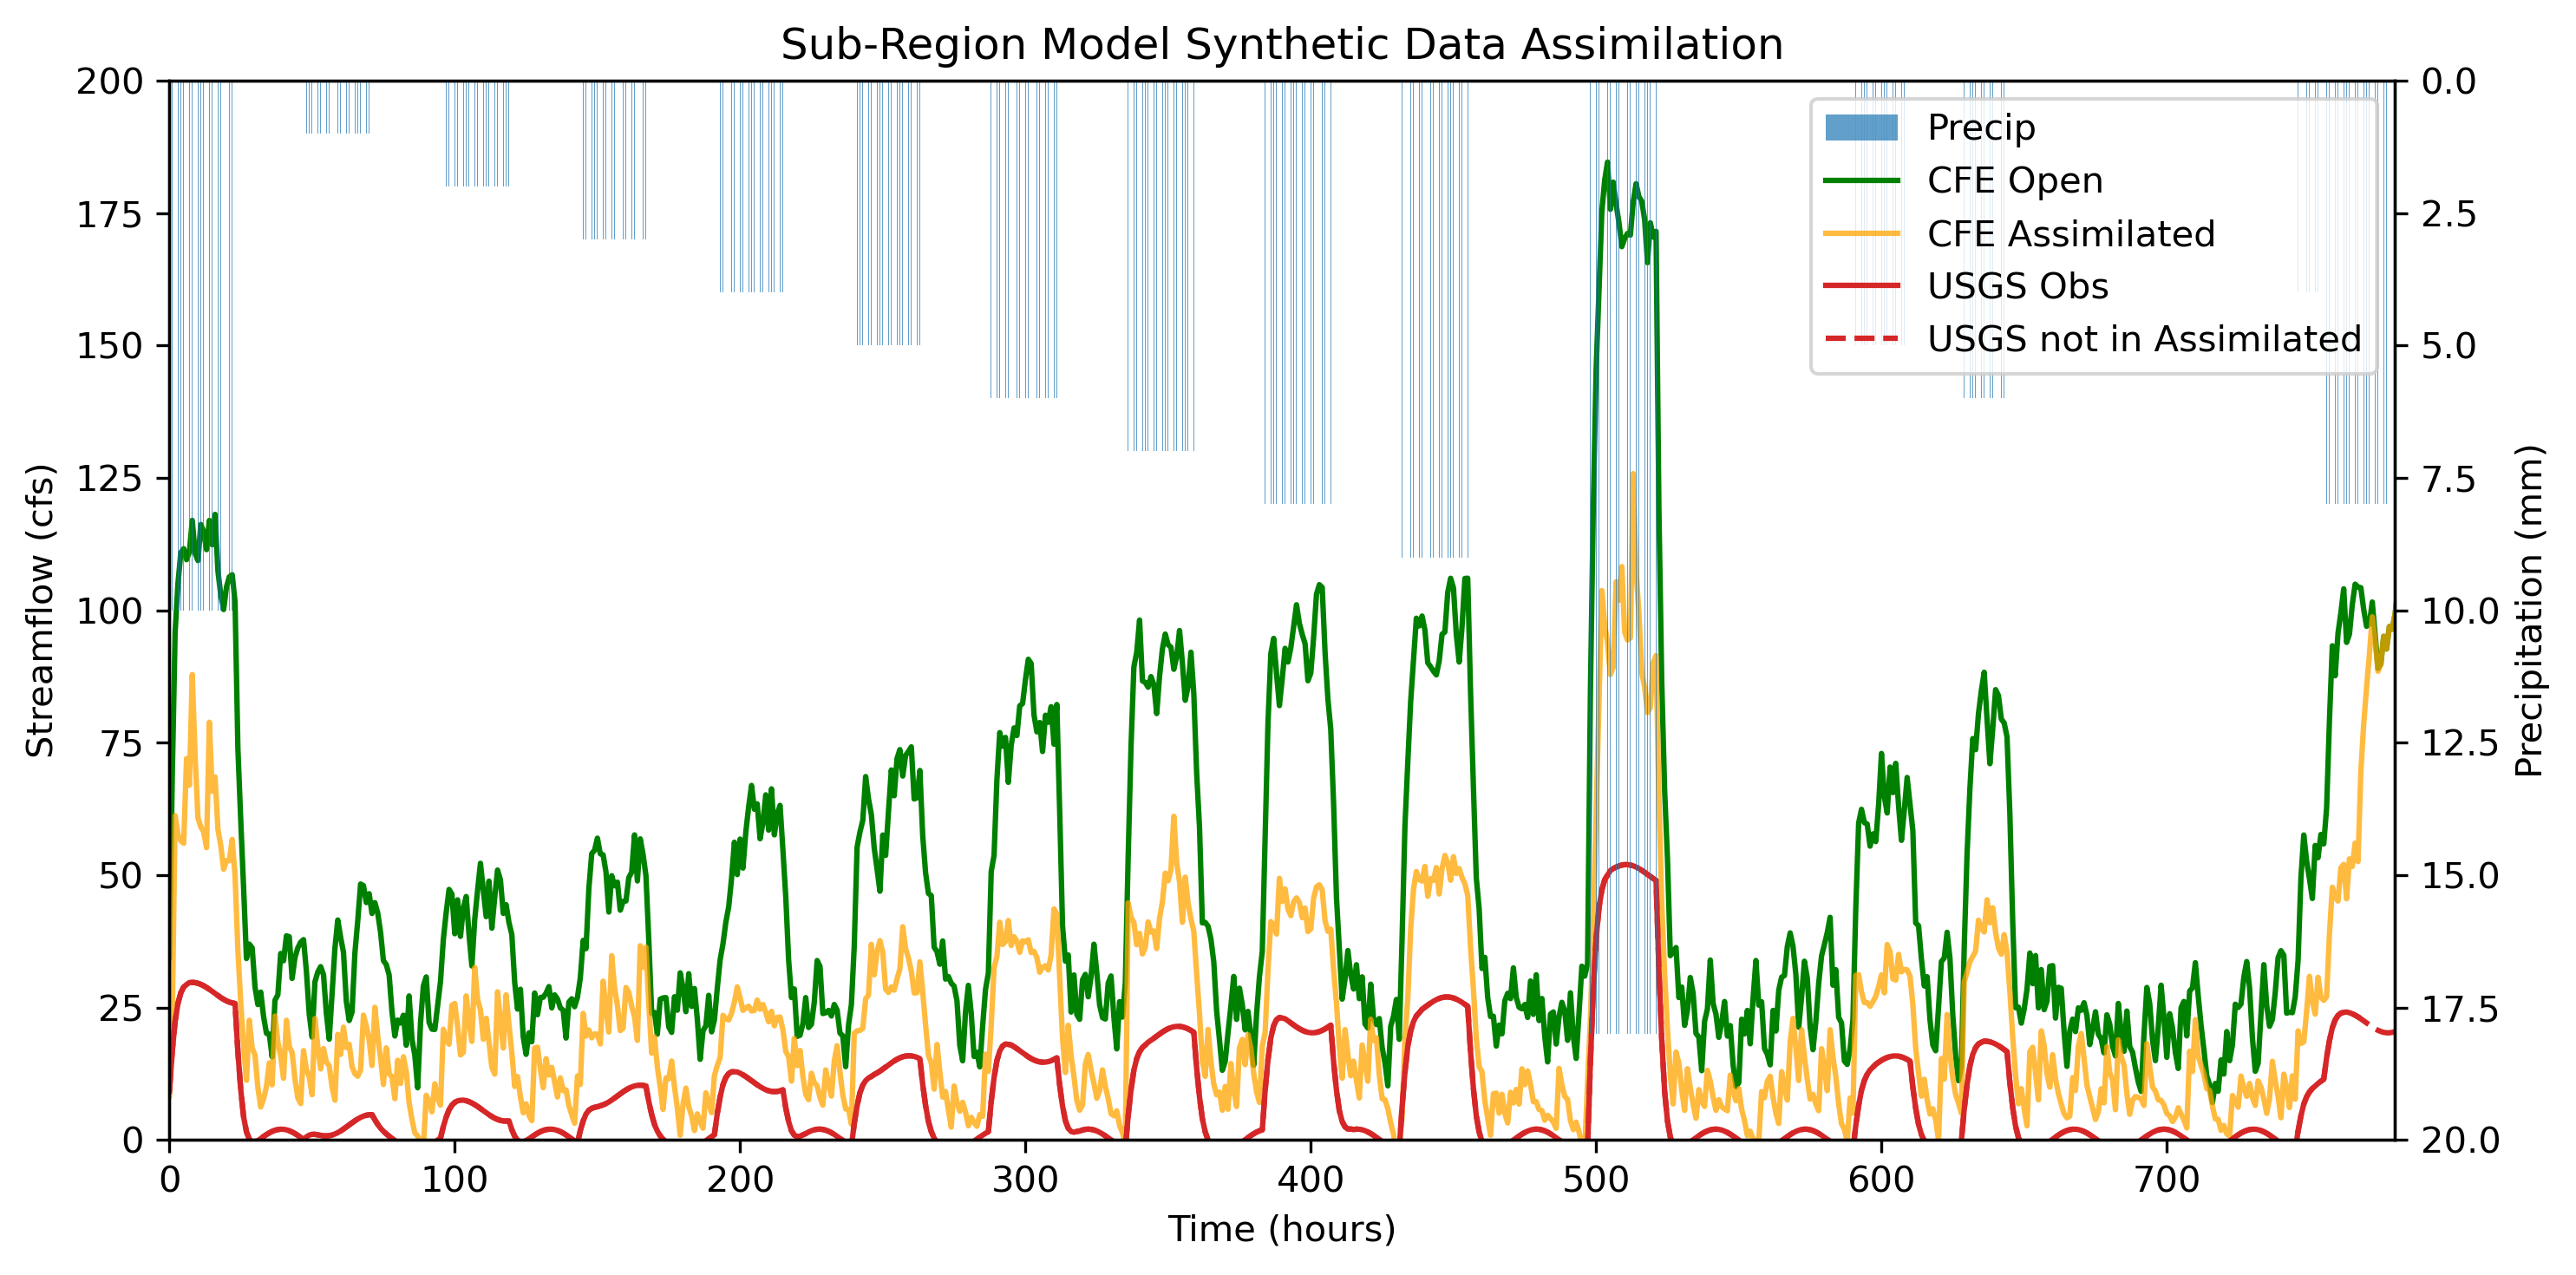

In [5]:
# Define time range for plotting
istart_plot=0
iend_plot=786
x = list(range(istart_plot, iend_plot))

# Set plotting dimensions
fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

# Make double y-axis to plot precipitation on top of of the plot. Set labels and limits for axes
ax2 = ax1.twinx()
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,20,1)
ax2.invert_yaxis()
plt.xlim(0,780)

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Streamflow (cfs)')
ax1.set_ylim(0,200,1)

plt.title('Sub-Region Model Synthetic Data Assimilation')

# Plot the variables on the plot! 
Precip = ax2.bar(x, df_forcing['APCP_surface_0'],width=0.2,alpha=0.7, color="tab:blue", label = 'Precip')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(OBSERVATIONS_LIST[istart_plot:768], color = 'tab:red', label = 'USGS Obs')
Obs2, = ax1.plot(OBSERVATIONS_LIST[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS not in Assimilated')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

# Plot the legend and fix layout
plt.legend(handles = [Precip,Open,Analysis,Obs,Obs2], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
fig.tight_layout()
ax1.margins(x=0)

#plt.savefig("WorkingDA_7-19.png")
plt.show()


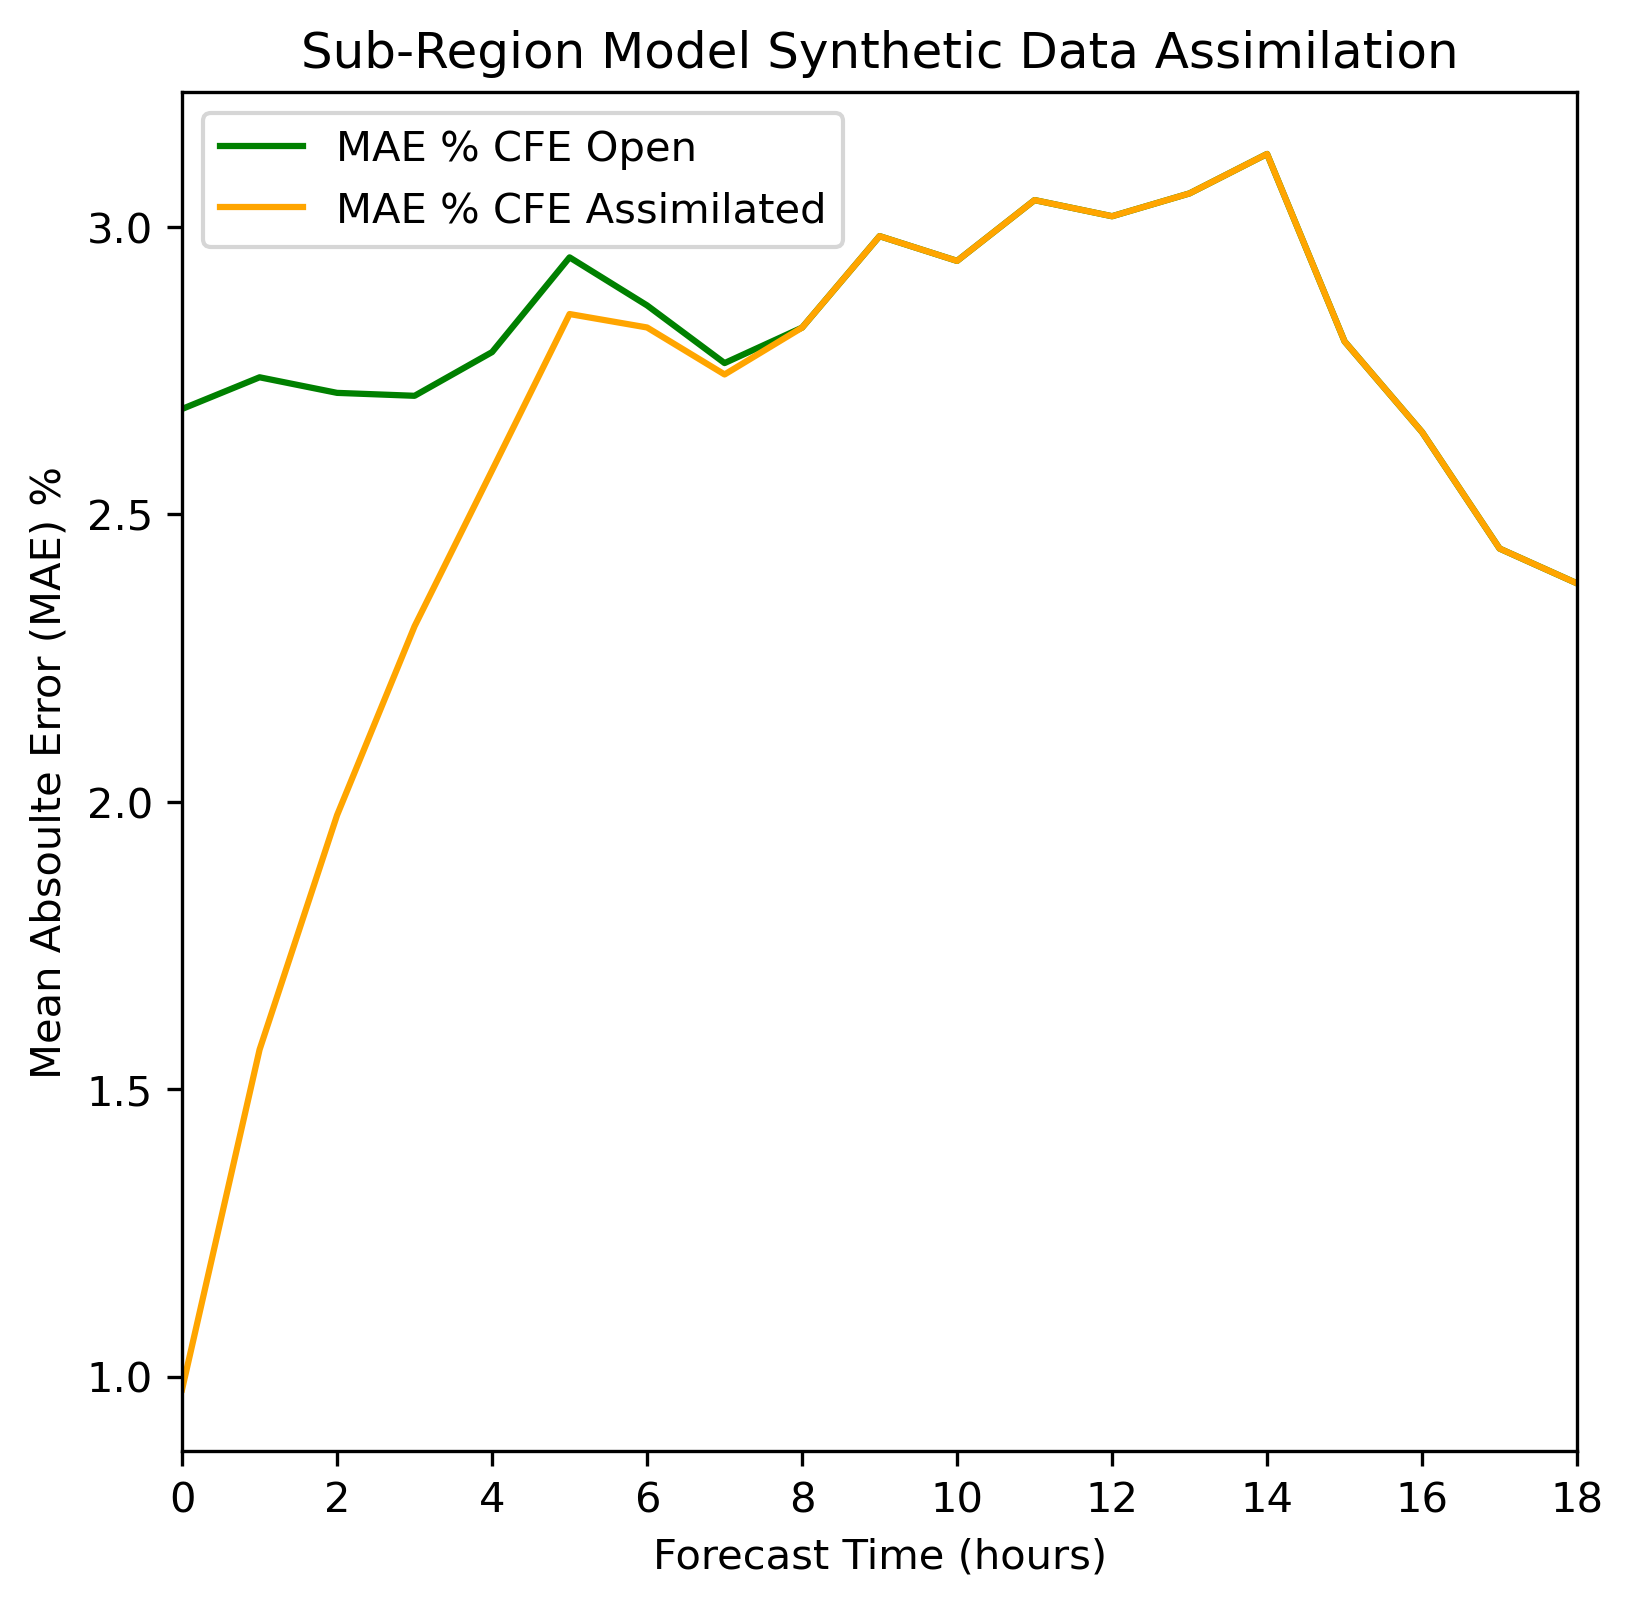

In [6]:
# Plot the Mean Absolute Error (MAE) of CFE Open vs CFE Assimilated
fig = plt.subplots(figsize = (6,6), dpi=300)

# Set labels and limits
plt.title('Sub-Region Model Synthetic Data Assimilation')
plt.xlim(0,18)
plt.xlabel('Forecast Time (hours)')
plt.ylabel('Mean Absoulte Error (MAE) %')

# Plot data
plt.plot(cfeOpen_ensa_mean, color = 'green', label = 'MAE % CFE Open')
plt.plot(cfeanalysis_ensa_mean, color = 'orange', label = 'MAE % CFE Assimilated')

# Show
plt.legend()
plt.show()


In [7]:
# Put values into dataframe to calculate statistics
df = pd.DataFrame({"obs":OBSERVATIONS_LIST,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True) #drop NaN values
df.reset_index(drop=True, inplace=True) #reset index


# CFE Open Evaluation
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias_open=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("CFE Open Statistics")
print("r_open     =",r_open[0])
print("KGE_open   =",kge_open[0])
print("NSE_open   =", nse_open[0])
print("PBIAS_open =", pbias_open[0])
print("--------------------------")

# CFE Analysis Evaluation
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("CFE Analysis Statistics")
print("r_analysis     =",r_analysis[0])
print("KGE_analysis   =",kge_analysis[0])
print("NSE_analysis   =", nse_analysis[0])
print("PBIAS_analysis =", pbias_analysis[0])
print("--------------------------")

# Mean and Std of Models and Observations
print("Mean and STD of Models and Observations")
print("mean_obs      =",np.mean(df["obs"]))
print("STD_obs       =",np.std(df["obs"]))
print("mean_open     =",np.mean(df["cfeOpen"]))
print("STD_open      =",np.std(df["cfeOpen"]))
print("mean_analysis =",np.mean(df["cfeAnalysis"]))
print("STD_analysis  =",np.std(df["cfeAnalysis"]))

CFE Open Statistics
r_open     = 0.9752711532378185
KGE_open   = -0.0767505289500583
NSE_open   = -0.8777810226868932
PBIAS_open = 84.00853906632571
--------------------------
CFE Analysis Statistics
r_analysis     = 0.9179471792319147
KGE_analysis   = 0.16867007965808134
NSE_analysis   = 0.15933513201295524
PBIAS_analysis = 66.9864149591036
--------------------------
Mean and STD of Models and Observations
mean_obs      = 7.82998928152997
STD_obs       = 11.330467618341043
mean_open     = 48.96356445483878
STD_open      = 34.65822995885161
mean_analysis = 23.717476523165754
STD_analysis  = 22.020020622733192
